In [1]:
import h5py
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
%matplotlib nbagg

In [2]:
lambdas = 418.2123 + 0.1465645*np.arange(1,2049)
nus = 299792458 / (lambdas[400:2047] * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=8, endpoint=True)
#filter = np.concatenate((np.ones(5), 1-signal.tukey(65), np.ones(1430), np.zeros(1500)))
filter = np.concatenate((np.ones(70),signal.tukey(40)[20:40], np.zeros(1557), np.zeros(1647)))
filter3 = np.concatenate((np.zeros(100), np.ones(100)))
#background_from_fit = np.loadtxt('/sf/alvra/data/p18594/scratch/philip/2020-07-23-psen_background_from_fit.txt')
background_from_fit = np.loadtxt('/das/work/p18/p18647/psen/2020-09-18-13:40-psen-background.txt')

In [5]:
# choose the data file(s):
datafiles = []
for file in glob.glob('/sf/alvra/data/p18647/raw/TD1_truezero-500fs/*.BSREAD.h5'):
    datafiles.append(file)
datafiles = sorted(datafiles)
datafiles
datafile = [datafiles[0]]
datafiles

['/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003873.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003874.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003875.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003876.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003877.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003878.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003879.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003880.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003881.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003882.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003883.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003884.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003885.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003886.BSREAD.h5',
 '/sf/alvra/data/p18

In [8]:
len(datafiles)

57

In [7]:
#p0 = 613.325 # determined manually. We need a better procedure for this in the future.
#px2fs = 1.5536 # determined from PSEN_calib_1.

px2fs = 1.4736525692795062    # from PSEN_calib_new2

#p0 = 551.894                  # determined on 18-9-2020 @ 14:00
#p0 = 522.935                  # determined on 18-9-2020 @ 22:00
p0 = 634.166                  # determined on 19-9-2020 @ 8:00

#Timezero = 165.55738          # determined on 18-9-2020 @ 10:30
#Timezero = 165.5464         # determined on 18-9-2020 @ 22:00
Timezero = 165.55265        # determined on 19-9-2020 @ 8:00


#for file in datafile:
for file in datafiles:
    print(file)
    # Load spectral data and spectrometer calibration
    with h5py.File(file, 'r') as f:
#        events = f['/data/SAR-CVME-TIFALL5:EvtSet/data'][:]
        back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
        sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]
        pulse_ids = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/pulse_id'][:]
        #stage_delay = f['/data/SLAAR11-LTIM01-EVR0:DUMMY_PV5_NBS/data'][0]  ## NBS PV, set to delay in fs from Delay Panel
        stage_delay_mm = f['/data/SLAAR11-LMOT-M451:ENC_1_BS/data'][0]    ## Topas Delay in mm.
    
    stage_delay = (stage_delay_mm - Timezero)*2/(3e8*1e3*1e-15)
    
    edgePos = [] # edge positions in fs
    peakAmp = [] # xcorr amplitudes in arb. units
    pids = [] # pulse ids
    
    for k in range(0, len(pulse_ids)):
        pids.append(int(pulse_ids[k]))
        
        # background subtraction
        sig2 = np.nan_to_num(sig[k, 400:2047] / back[k, 400:2047]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
        sig4savgol = savgol_filter(sig4invreal[0:1647], 201, 3)
        sig5 = sig4savgol
        
        # cross correlation, isolate the peak, save it if we have no division by zero errors
        xcorr2 = np.correlate(sig5, filter3, 'same')
        peak2 = savgol_filter(np.diff(xcorr2)[250:1647-250], 201, 3)
        peakxcorr, peakxcorr2 = find_peaks(peak2[:],height=np.max(peak2[:]))
        #if (peakxcorr > 0) & (peak2.max() > 0.05): 
        edgePos.append((p0 - peakxcorr.mean())*px2fs)
        peakAmp.append(np.max(peak2))
          
    hf = h5py.File('/das/work/p18/p18647/psen/specenc/TD1_truezero-500fs/' + file.split('.')[0].split('/')[-1] + '.SPECENC.h5', 'w')
    hf.create_dataset('pulse_ids', data=pids)
    hf.create_dataset('nominal_delay_from_stage', data=stage_delay)
    hf.create_dataset('arrival_times', data=edgePos)
    hf.create_dataset('arrival_times_amplitude', data=peakAmp)
    hf.close()

/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003873.BSREAD.h5


/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: Mean of empty slice.
/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003874.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003875.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003876.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003877.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003878.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003879.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003880.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003881.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003882.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003883.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003884.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003885.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003886.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003887.BSREAD.h5
/sf/alvra/data/p18647/raw/TD1_truezero-500fs/run_003888.BSREAD.h5
/sf/alvra/

In [15]:
check = []
for f in glob.glob('/das/work/p18/p18647/psen/specenc/TD1_truezero_250fs/*.SPECENC.h5'):
    check.append(f)
len(check)

21

In [29]:
len(peakAmp)
#peakxcorr.mean()
#file[26:52]
#file[42:52]

4000

<IPython.core.display.Javascript object>


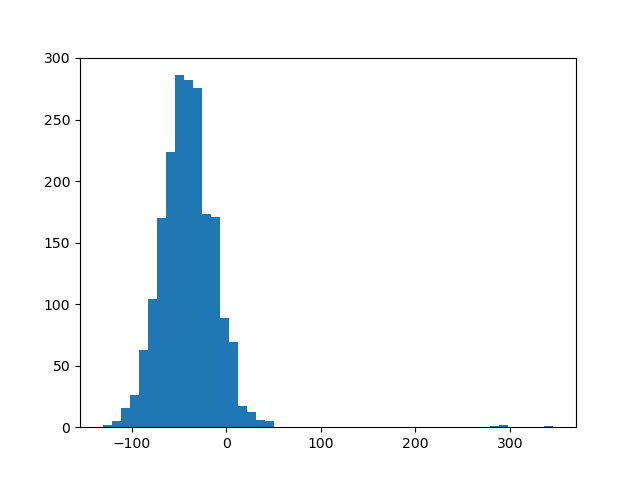

4000

In [38]:
plt.figure()
plt.hist(edgePos, bins=50)
plt.show()
len(edgePos)

<IPython.core.display.Javascript object>


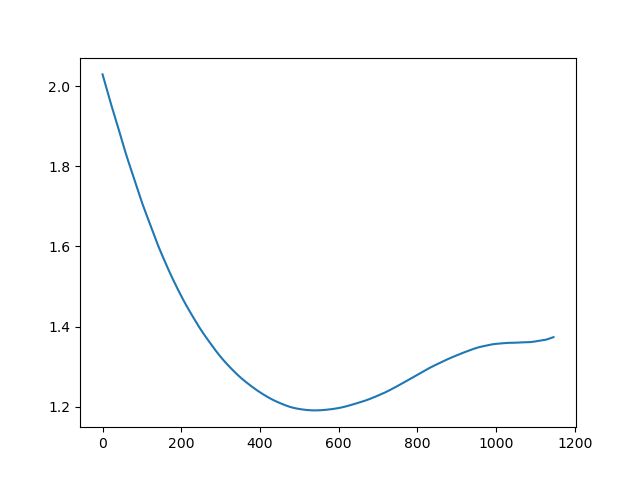

In [31]:
plt.figure()
plt.plot(sig5[250:1647-250])
#plt.plot(np.nan_to_num(peakAmp), 'o')
plt.show()

In [50]:
p0 = 613.325            # determined manually. We need a better procedure for this in the future.
px2fs = 1.5536          # determined from PSEN_calib_1.
Timezero = 165.55738    # in mm to calculate Delay stage in fs in case the value in mm is read from the BSREAD file.

check = '/sf/alvra/data/p18594/raw/rho_nlsa_scan_7/run_001997.BSREAD.h5'
    # Load spectral data and spectrometer calibration
with h5py.File(check, 'r') as f:
    events = f['/data/SAR-CVME-TIFALL5:EvtSet/data'][:]
    back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
    sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]
    #pulse_ids = f['/data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/pulse_id'][:]
    pulse_ids = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/pulse_id'][:]
    #stage_delay = f['/data/SLAAR11-LTIM01-EVR0:DUMMY_PV5_NBS/data'][0]  ## NBS PV, set to delay in fs from Delay Panel
    stage_delay = f['/data/SLAAR11-LMOT-M451:ENC_1_BS/data'][0]    ## Topas Delay in mm.
    i0 = f['/data/SAROP11-PBPS122:INTENSITY/data'][:]

edgePos = [] # edge positions in fs
peakAmp = [] # xcorr amplitudes in arb. units
pids = [] # pulse ids
    
for k in range(0, len(pulse_ids)):
    pids.append(int(pulse_ids[k]))
    fel = events[k][48]
    laser = events[k][18]
    darkShot = events[k][21]
        
    # background subtraction
    sig2 = np.nan_to_num(sig[k, 400:2047] / back[k, 400:2047]) / background_from_fit
    
    # interpolate to get evenly sampled in frequency space
    sig3inter = interp1d(nus, sig2, kind='cubic')
    sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
    sig4power = np.abs(np.fft.fft(sig4))**2

    # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
    sig4fft = np.fft.fft(sig4)
    sig4filtered = sig4fft * filter
    sig4inverse = np.fft.ifft(sig4filtered)
    sig4invreal = 2 * np.real(sig4inverse)
    sig4savgol = savgol_filter(sig4invreal[0:1647], 201, 1)
    sig5 = sig4savgol
        
    # cross correlation, isolate the peak, save it if we have no division by zero errors
    xcorr2 = np.correlate(sig5, filter3, 'same')
    peak2 = savgol_filter(np.diff(xcorr2)[250:1647-250], 201, 3)
    peakxcorr, peakxcorr2 = find_peaks(peak2[:],height=np.max(peak2[:]))
    #if (peakxcorr > 0) & (peak2.max() > 0.05): 
    edgePos.append((p0 - peakxcorr.mean())*px2fs)
    peakAmp.append(np.max(peak2))

/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice.


<IPython.core.display.Javascript object>


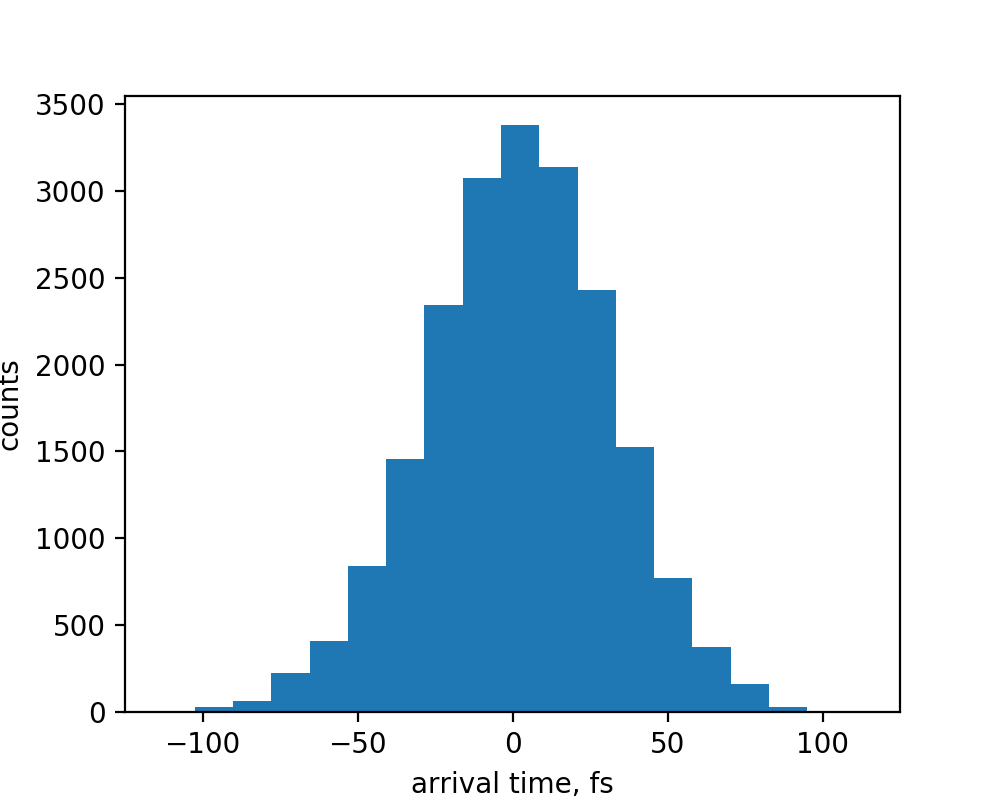

In [127]:
plt.figure(figsize=(5,4))
#plt.plot(edgePos)
plt.hist(np.asarray(edgePos) + 51, bins=20)
plt.xlim(-125, 125)
plt.xlabel('arrival time, fs')
plt.ylabel('counts')
plt.show()

In [6]:
print(np.shape(pulse_ids))
print(np.shape(pids))
print(np.shape(sig))
print(np.shape(peakAmp))
print(np.shape(edgePos))

(1000,)
(1000,)
(1000, 2047)
(1000,)
(1000,)


<IPython.core.display.Javascript object>


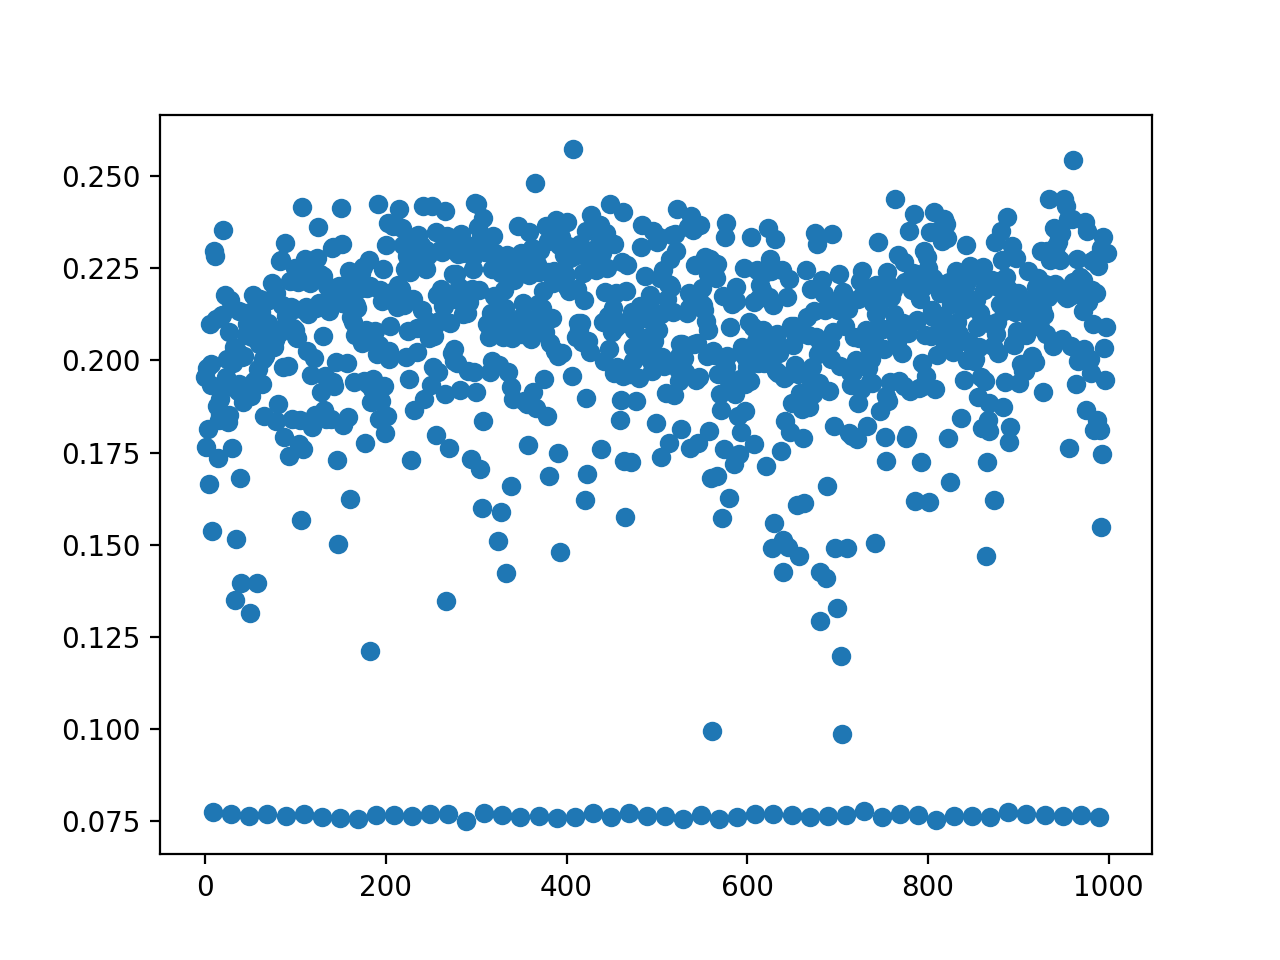

In [25]:
plt.figure()
plt.plot(peakAmp, 'o')
#plt.plot(i0/15, 'o')
plt.show()